In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
import dxfgrabber
from ezdxf.groupby import groupby
import scipy.interpolate

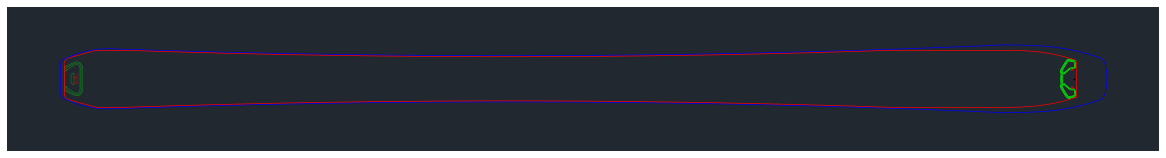

In [254]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile('DY-S76-176-1.dxf')
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

Get all entities in each layer

In [255]:
msp = doc.modelspace()
group = groupby(entities=msp, dxfattrib='layer')
group = msp.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))


Layer "Accessoires" contains following entities:
    INSERT(#2099)
Layer "Peau" contains following entities:
    LINE(#20C6)
    ARC(#20C8)
    ARC(#20C9)
    LINE(#20CA)
    CIRCLE(#20CC)
    LINE(#20CD)
    LINE(#210C)
    LINE(#210D)
    INSERT(#213E)
    INSERT(#219A)
    INSERT(#21FD)
    INSERT(#21FE)
    ELLIPSE(#2201)
    SPLINE(#2202)
    SPLINE(#2203)
    LINE(#2206)
    SPLINE(#2207)
    LINE(#2208)
    SPLINE(#2209)
    LINE(#220A)
    ELLIPSE(#220B)
    LINE(#220C)
    CIRCLE(#220D)
Layer "TAIL-HOOK-2013-2D-PATCH" contains following entities:
    INSERT(#20CB)
Layer "2_Ski" contains following entities:
    LINE(#2101)
    SPLINE(#2102)
    SPLINE(#2103)
    SPLINE(#2104)
    SPLINE(#2105)
    SPLINE(#2106)
    SPLINE(#2107)


Get just ski-layer entities

In [256]:
q = []
if layer == '2_Ski':
    print(f'Ski layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))
        q.append(entity)

Ski layer "2_Ski" contains following entities:
    LINE(#2101)
    SPLINE(#2102)
    SPLINE(#2103)
    SPLINE(#2104)
    SPLINE(#2105)
    SPLINE(#2106)
    SPLINE(#2107)


Plot control points from spline and line in SKI LAYER

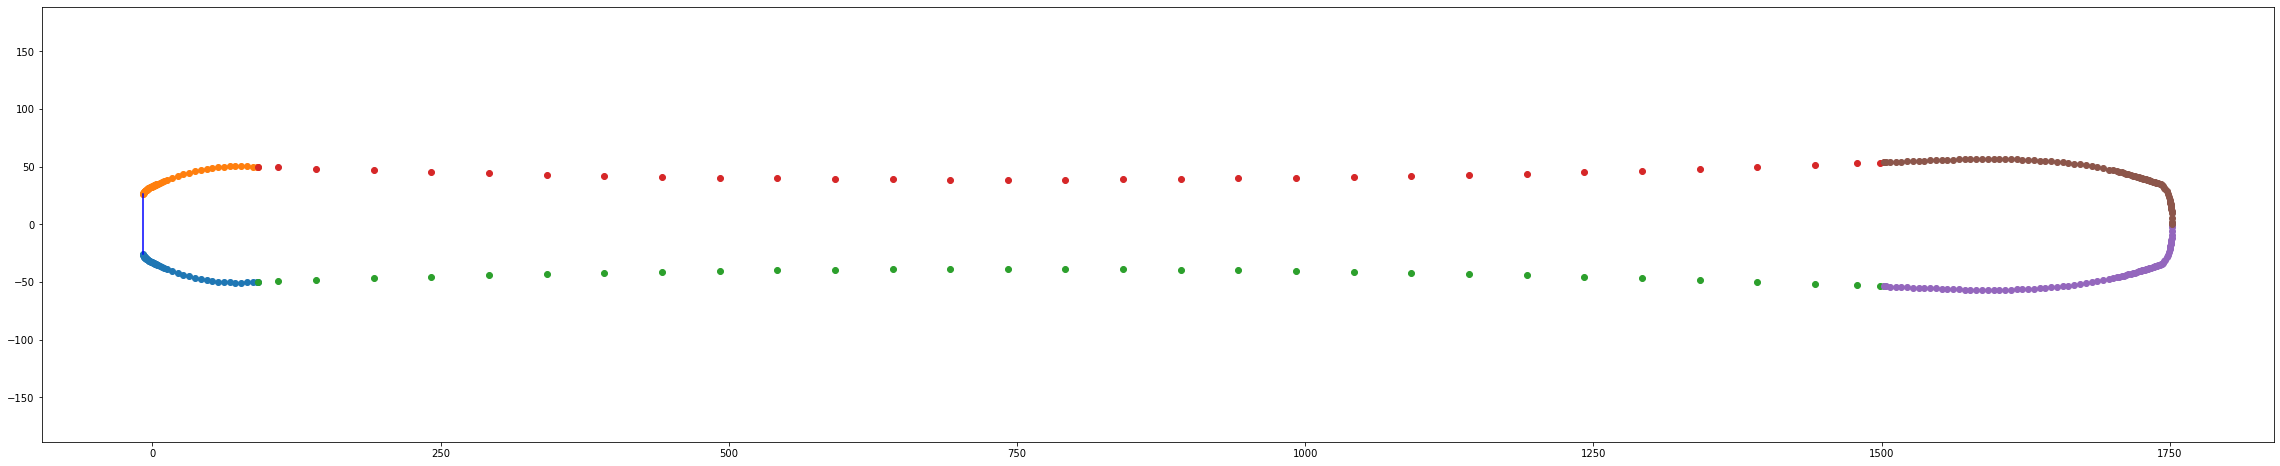

In [257]:
plt.figure(figsize=(40, 8))

for spline in msp.query('SPLINE[layer=="2_Ski"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
   
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'o')

for line in msp.query('LINE[layer=="2_Ski"]'):
    plt.plot([np.array(line.dxf.start)[0],np.array(line.dxf.end)[0]],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')

plt.axis('equal')
plt.show()

Fit control points and increase data density up to one point every cm

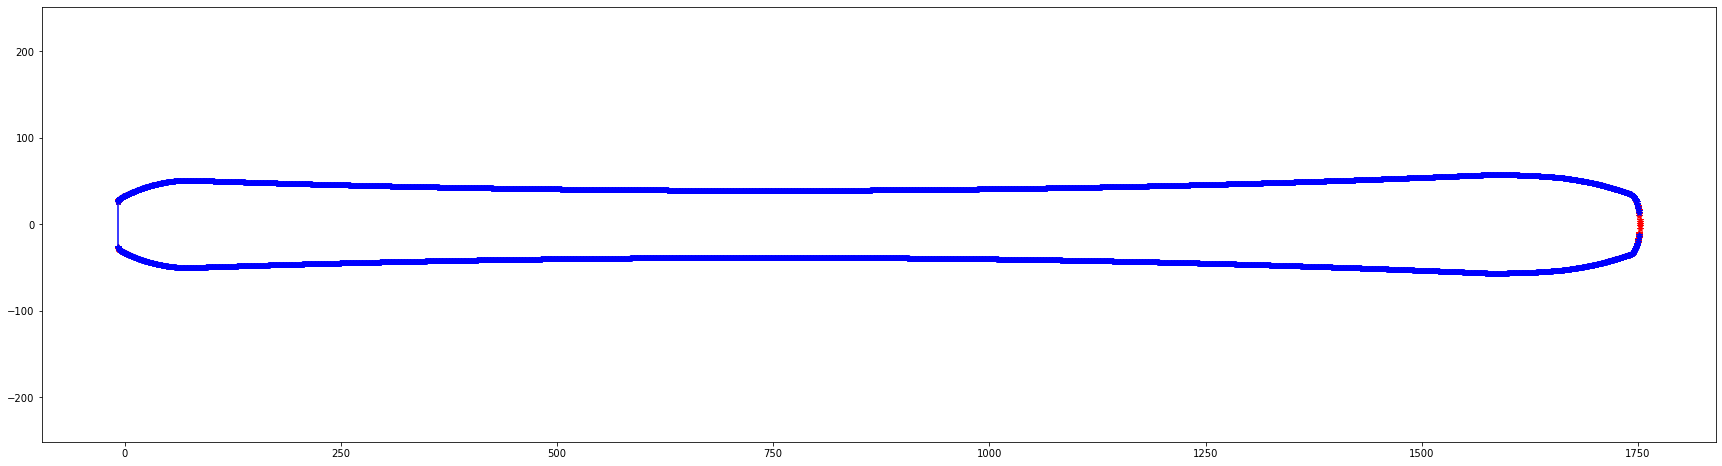

In [258]:
plt.figure(figsize=(30, 8))
tot_x = []
tot_y = []
for spline in msp.query('SPLINE[layer=="2_Ski"]'):
    
    points = np.array(spline.control_points)
    x_nodes = points[:,0] 
    y_nodes = points[:,1]
        
    if x_nodes[0]>x_nodes[1]:
        x_nodes = x_nodes[::-1]
        y_nodes = y_nodes[::-1]
        points = points[::-1]
              
    #Plot control points coming from dxf file 
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], '*r')    

    #For each spline create myspline from control_points
    myspline = scipy.interpolate.UnivariateSpline(x_nodes, y_nodes, s=0)
    myspline_knots = myspline.get_knots()
    myspline_coeffs = myspline.get_coeffs()

    #Myspline evaluation in more points
    x = np.arange(x_nodes[0], x_nodes[-1], 0.5)
    tot_x = np.append(tot_x, x)
    
    y_myspline = myspline(x)
    tot_y = np.append(tot_y,y_myspline)
    
    y_knots = myspline(myspline_knots)

    #plt.plot(x, y_myspline, 'b*', label='myspline')

for line in msp.query('LINE[layer=="2_Ski"]'):
    plt.plot([np.array(line.dxf.start)[0],np.array(line.dxf.end)[0]],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')

plt.plot(tot_x, tot_y, 'b*', label='myspline')
plt.axis('equal')
plt.show()

Flip data to have ski from tip to tail and starting from zero

In [259]:
tot_x = tot_x - np.min(tot_x)
tot_x = tot_x - np.max(tot_x)
tot_x = -tot_x

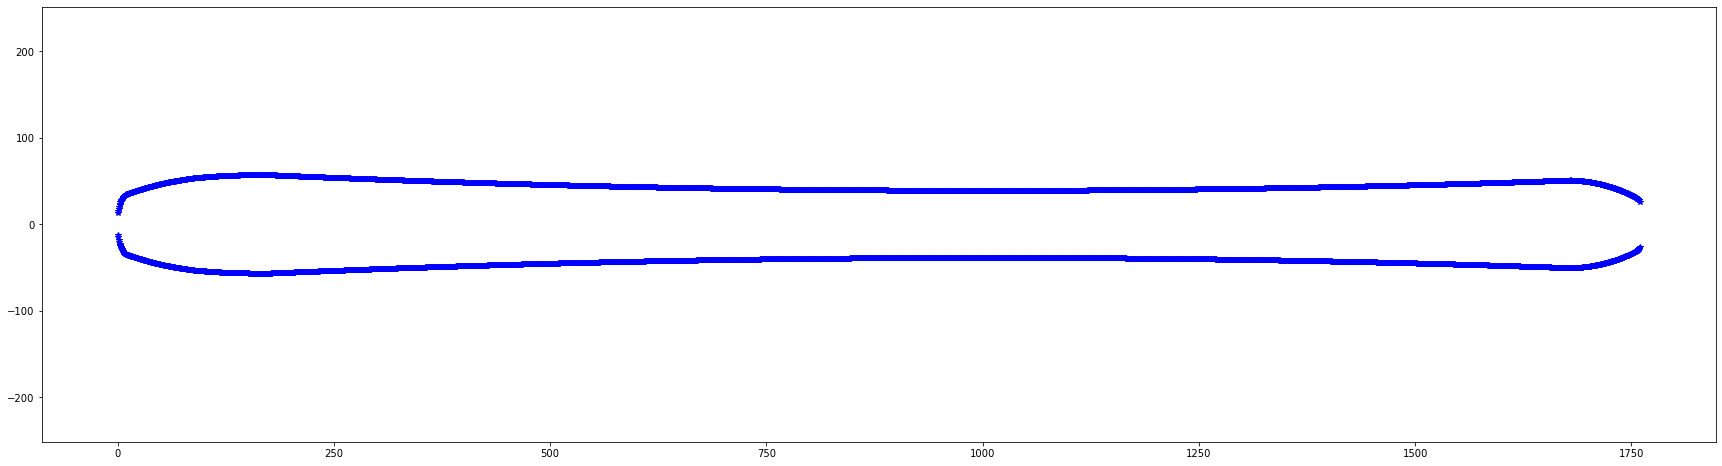

In [261]:
plt.figure(figsize=(30, 8))
plt.plot(tot_x, tot_y, 'b*', label='myspline')
plt.axis('equal')
plt.show()

Loading cleaned sensors data 

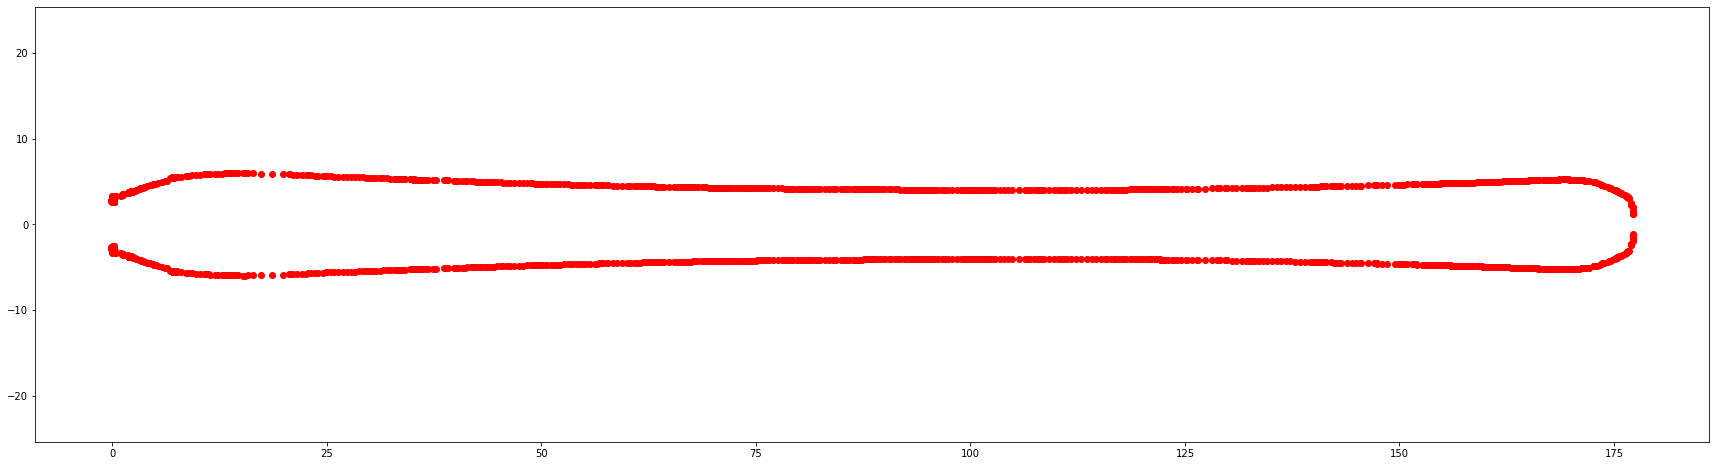

In [262]:
ski_profile = pd.read_csv(r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\sensorsdata.csv', sep = ",")

# Plot two sides of the ski

plt.figure(figsize=(30, 8))

plt.plot(ski_profile['L'], ski_profile['W'], 'ro')
plt.plot(ski_profile['L'], -ski_profile['W'], 'ro')

plt.axis('equal')
plt.show()

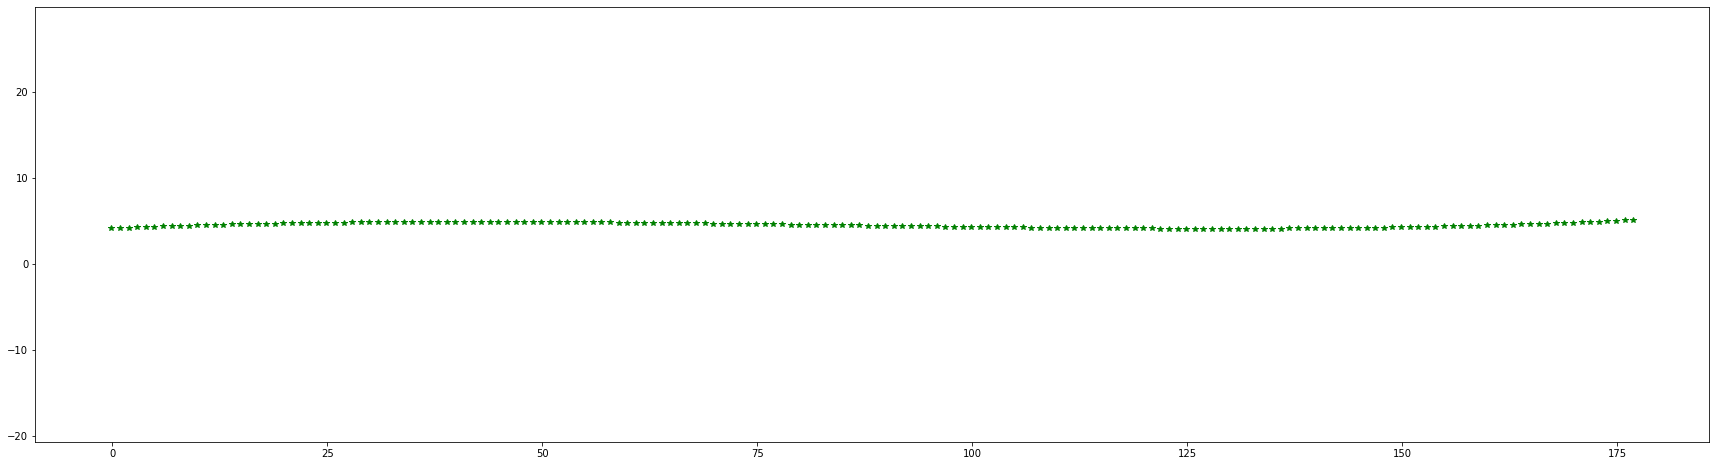

In [273]:
ski_profile = ski_profile.sort_values('L',ascending=True)
x_nodes = ski_profile['L'].to_numpy()
y_nodes = ski_profile['W'].to_numpy()
myspline2 = scipy.interpolate.UnivariateSpline(x_nodes, y_nodes) #we need to divide ski sections (TBD)
myspline2_knots = myspline2.get_knots()
myspline2_coeffs = myspline2.get_coeffs()

#Myspline evaluation in more points
x = np.arange(x_nodes[0], x_nodes[-1], 1)

y_myspline2 = myspline2(x)

plt.figure(figsize=(30, 8))
plt.plot(x, y_myspline2, 'g*', label='myspline')
plt.axis('equal')
plt.show()